In [1]:
%pip install -Uqq fastai

Note: you may need to restart the kernel to use updated packages.


In [2]:
from fastcore.all import *
import time

def search_images(term, max_images=200):
    url = 'https://duckduckgo.com/'
    res = urlread(url, data = {'q':term})
    searchObj = re.search(r'vqd=([\d-]+)\&', res)
    requestUrl = url + 'i.js'
    params = dict(l='us-en', o='json', q=term, vqd=searchObj.group(1), f=',,,', p='1', v7exp='a')
    urls, data = set(), {'next':1}
    while len(urls) < max_images and 'next' in data:
        data = urljson(requestUrl, data=params)
        urls.update(L(data['results']).itemgot('image'))
        requestUrl = url + data['next']
        time.sleep(0.2)
    return L(urls)[:max_images]

In [3]:
urls = search_images('bird photos', max_images=1)
urls[0]

'http://2.bp.blogspot.com/-TQ1S9XhEEp8/Un6hh6fGCqI/AAAAAAAAWPg/hEx0QsLVIEk/s1600/1600x1200-beautiful-bird-sitting-on-branch-hd-bird-wallpaper-animal.jpg'

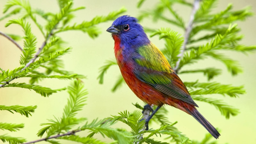

In [4]:
from fastdownload import download_url
dest = 'bird.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

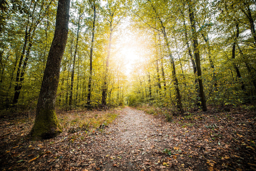

In [5]:
download_url(search_images('forest photos', max_images=1)[0], 'forest.jpg', show_progress=False)
Image.open('forest.jpg').to_thumb(256, 256)

In [6]:
searches = 'forest', 'bird'
path = Path('bird_or_not')

for o in searches:
    dest = (path / o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    resize_images(dest, max_size=400, dest=dest)

In [9]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

0

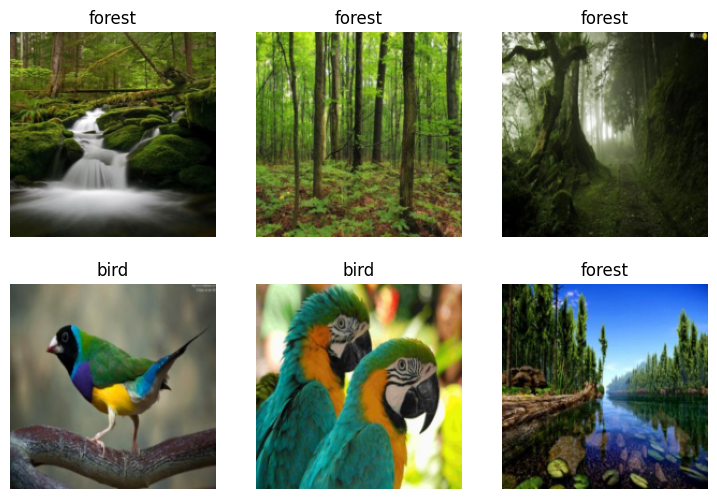

In [14]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), # (type of input to model, type of output to model)
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42), # how much data to 'set aside' to validate the model
    get_y=parent_label, # literally the parent folder
    item_tfms=[Resize(192, method='squish')] # get all the inputs to be the same size - 192x192 pixels
).dataloaders(path)

dls.show_batch(max_n=6)

In [16]:
# resnet18 here is the model. it's a neural network function builtin to fastai. they actually come from "timm"
# resnet probably fine for pretty much everything we want to do
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

resnet18 is pre-trained weights
we're fine-tuning those weights to teach the differences between our dataset and the original thing it's trained for

In [19]:
is_bird, _, probs = learn.predict(PILImage.create('bird.jpg'))
print(f"This is a: {is_bird}.")
print(f"Probability it's a bird: {probs[0]:.4f}")

This is a: bird.
Probability it's a bird: 1.0000


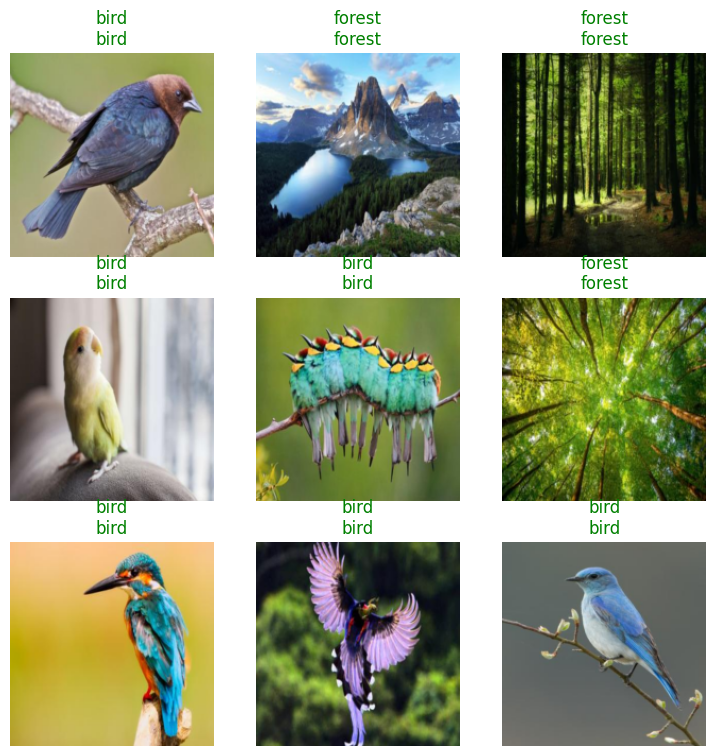

In [20]:
learn.show_results()